In [ ]:
!wget  http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2 
  
!pip install -U -q PyDrive
import os
from os import chdir, listdir, stat
from sys import exit
import ast
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.files import GoogleDriveFileList
import googleapiclient.errors
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.models import model_from_json
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import math
import numpy as np
import matplotlib.pyplot as plt
import _pickle
import six.moves.cPickle as pickle
import  random, sys, keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D,ZeroPadding3D, Conv3D
from keras.regularizers import *
from keras.optimizers import adam

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

def upload_files(drive, folder_id, src_files, src_folder_name='.'):
    try:
        chdir(src_folder_name)
    except OSError:
        print(src_folder_name + ' is missing')
    for file1 in listdir('.'):
        statinfo = stat(file1)
        if file1 in src_files and statinfo.st_size > 0:
            print('Uploading ' + file1)
            f = drive.CreateFile(
                {"parents": [{"kind": "drive#fileLink", "id": folder_id}]})
            f.SetContentFile(file1)
            f.Upload()

def load_files(list_files):
  file_list = drive.ListFile(
    {'q': "'1NkJvoaOCcJiKuNHy7Eg3SLdpEp3fjGu3' in parents"}).GetList()

  for f in file_list:
    if f['title'] in list_files:
      print('title: %s, id: %s' % (f['title'], f['id']))
      fname = os.path.join(local_download_path, f['title'])
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)  


!bzip2 -d ./2016.04C.multisnr.pkl.bz2

--2018-05-13 23:55:39--  http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2
Connecting to 104.197.136.14:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111458161 (106M) [application/x-bzip2]
Saving to: ‘2016.04C.multisnr.pkl.bz2.9’

2016.04C.multisnr.p 100%[===================>] 106.29M  26.5MB/s    in 4.7s    

2018-05-13 23:55:44 (22.5 MB/s) - ‘2016.04C.multisnr.pkl.bz2.9’ saved [111458161/111458161]

bzip2: Output file ./2016.04C.multisnr.pkl already exists.


In [ ]:
import _pickle
import numpy as np
with open ('./2016.04C.multisnr.pkl','rb') as f:
  data=_pickle.load(f, encoding="latin1")

In [ ]:
#reads the data set's keys 
mods,snrs = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [0,1])
  

In [ ]:
formatedData=[]
labels=[]
for mod in mods:
  for snr in snrs:
    formatedData.append(data[(mod,snr)])
    for i in range(data[(mod,snr)].shape[0]):
            
            labels.append((mod,snr))
formatedData = np.vstack(formatedData)


print ("Dataset formatted into shape: ",formatedData.shape)

print ("Dataset with SNRs: ",snrs)
print ("Dataset with Modulations: ",mods)
print ("Data prepared")
print (labels)

Dataset formatted into shape:  (162060, 2, 128)
Dataset with SNRs:  [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Dataset with Modulations:  ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Data prepared
[('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK'

In [ ]:
np.random.seed(2018)
n_examples = formatedData.shape[0]
'''n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))'''
train_idx = []
test_idx = []
validation_idx = []
labels_train=[]
labels_test=[]
labels_test2 = []
labels_test3 = []
labels_validation=[]
formatedData_train = []
formatedData_test = []
formatedData_validation = []
label = []
for label in data.keys():
  current_data = data[label]
  size = current_data.shape[0]
  for i in range(0,int(0.9*size)):
    formatedData_train.append([current_data[i]])
    labels_train.append(label[0])
  for i in range(int(0.9*size) , int(0.95*size) ):
    formatedData_test.append([current_data[i]])
    labels_test.append(label[0])
    labels_test2.append(label)
    labels_test3.append(label[1])
    test_idx.append(i)
  for i in range(int(0.95*size) , size ):
    formatedData_validation.append([current_data[i]])
    labels_validation.append(label[0])
    
formatedData_train = np.vstack(formatedData_train)
formatedData_test = np.vstack(formatedData_test)
formatedData_validation = np.vstack(formatedData_validation)
print (formatedData_train.shape)
print (formatedData_test.shape)
print (formatedData_validation.shape)
print(len(labels_test))
print(len(labels_train))
print(len(labels_validation))
'''def to_onehot(yy):
    yy1 = np.zeros([len(list(yy)), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(map(lambda x: mods.index(labels[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(labels[x][0]), test_idx))

in_shp = list(formatedData_train.shape[1:])
# print X_train.shape, in_shp
classes = mods
'''

(145760, 2, 128)
(8060, 2, 128)
(8240, 2, 128)
8060
145760
8240


'def to_onehot(yy):\n    yy1 = np.zeros([len(list(yy)), max(yy)+1])\n    yy1[np.arange(len(yy)),yy] = 1\n    return yy1\n\nY_train = to_onehot(map(lambda x: mods.index(labels[x][0]), train_idx))\nY_test = to_onehot(map(lambda x: mods.index(labels[x][0]), test_idx))\n\nin_shp = list(formatedData_train.shape[1:])\n# print X_train.shape, in_shp\nclasses = mods\n'

In [ ]:
import numpy as np
n= len(mods)
mods_matrix = np.zeros( (n , n) ,  dtype=np.int)
i =0
for mod_vector in mods_matrix:
  mod_vector[i] = 1
  i = i+1
mods_dict = {}
for mod , mod_vector in zip(mods , mods_matrix):
  mods_dict[mod] = mod_vector
  

labels_train_matrix = []
labels_test_matrix = []
labels_validation_matrix = []
for label in labels_train:
  labels_train_matrix.append(mods_dict[label])

for label in labels_test:
  labels_test_matrix.append(mods_dict[label])
  
for label in labels_validation:
  labels_validation_matrix.append(mods_dict[label])
  
  


In [ ]:
from sklearn.utils import shuffle
formatedData_train, labels_train_matrix = shuffle(formatedData_train, labels_train_matrix)
formatedData_test, labels_test_matrix,labels_test,labels_test2= shuffle(formatedData_test, labels_test_matrix,labels_test,labels_test2)
formatedData_validation, labels_validation_matrix = shuffle(formatedData_validation, labels_validation_matrix)
formatedData_train_2D = []
for row in formatedData_train:
  formatedData_train_2D.append(row.flatten())
formatedData_train_2D = np.vstack(formatedData_train_2D)

formatedData_test_2D = []
for row in formatedData_test:
  formatedData_test_2D.append(row.flatten())
formatedData_test_2D = np.vstack(formatedData_test_2D)

formatedData_validation_2D = []
for row in formatedData_validation:
  formatedData_validation_2D.append(row.flatten())
formatedData_validation_2D = np.vstack(formatedData_validation_2D)

folder_id = '1NkJvoaOCcJiKuNHy7Eg3SLdpEp3fjGu3'


In [ ]:
formatedData_train_diff = []
formatedData_test_diff = []
formatedData_validation_diff = []
#print(np.array(formatedData_train).shape)
for signal in formatedData_train:
  formatedData_train_diff.append ( np.gradient(signal) )
  
for signal in formatedData_test:
  formatedData_test_diff.append ( np.gradient(signal))
  
for signal in formatedData_validation:
  formatedData_validation_diff.append ( np.gradient(signal) )
  

formatedData_train_2D_diff = []
formatedData_test_2D_diff = []
formatedData_validation_2D_diff = []

for signal in formatedData_train_2D:
  formatedData_train_2D_diff.append ( np.gradient(signal) )
  
for signal in formatedData_test_2D:
  formatedData_test_2D_diff.append ( np.gradient(signal) )
  
for signal in formatedData_validation_2D:
  formatedData_validation_2D_diff.append ( np.gradient(signal) ) 
  
formatedData_train_3D_diff = np.array(formatedData_train_2D_diff).reshape(145760, 2, 128)
formatedData_test_3D_diff = np.array(formatedData_test_2D_diff).reshape(8060, 2, 128)
formatedData_validation_3D_diff = np.array(formatedData_validation_2D_diff).reshape(8240, 2, 128)

print(formatedData_train_3D_diff.shape)
print(formatedData_test_3D_diff.shape)
print(formatedData_validation_3D_diff.shape)


(145760, 2, 128)
(8060, 2, 128)
(8240, 2, 128)


In [ ]:
from scipy.interpolate import UnivariateSpline
formatedData_train_2D_int = []
formatedData_test_2D_int = []
formatedData_validation_2D_int = []
x= np.linspace(0,255,256)
for signal in formatedData_train_2D:
  f= UnivariateSpline(x, np.array(signal) , s=0 )
  f_int = f.antiderivative()
  signal_int = f_int.get_coeffs()
  formatedData_train_2D_int.append ( signal_int )
formatedData_train_2D_int = np.delete(np.array(formatedData_train_2D_int) , 256 , axis=1)

for signal in formatedData_test_2D:
  f= UnivariateSpline(x, np.array(signal) , s=0 )
  f_int = f.antiderivative()
  signal_int = f_int.get_coeffs()
  formatedData_test_2D_int.append ( signal_int )
  
formatedData_test_2D_int = np.delete(np.array(formatedData_test_2D_int) , 256 , axis=1)

for signal in formatedData_validation_2D:
  f= UnivariateSpline(x, np.array(signal) , s=0 )
  f_int = f.antiderivative()
  signal_int = f_int.get_coeffs()
  formatedData_validation_2D_int.append ( signal_int )

formatedData_validation_2D_int = np.delete(np.array(formatedData_validation_2D_int) , 256 , axis=1)


formatedData_train_3D_int = np.array(formatedData_train_2D_int).reshape(145760, 2, 128)
formatedData_test_3D_int = np.array(formatedData_test_2D_int).reshape(8060, 2, 128)
formatedData_validation_3D_int = np.array(formatedData_validation_2D_int).reshape(8240, 2, 128)

print(formatedData_train_3D_int.shape)
print(formatedData_test_3D_int.shape)
print(formatedData_validation_3D_int.shape)


(145760, 2, 128)
(8060, 2, 128)
(8240, 2, 128)


In [ ]:
Data_original_diff_train = np.hstack( (np.array(formatedData_train_2D) , np.array(formatedData_train_2D_diff )) )
Data_original_diff_test = np.hstack((np.array(formatedData_test_2D) , np.array(formatedData_test_2D_diff )) )
Data_original_diff_validation = np.hstack((np.array(formatedData_validation_2D) , np.array(formatedData_validation_2D_diff )))

print(Data_original_diff_train.shape)
print(Data_original_diff_test.shape)
print(Data_original_diff_validation.shape)

Data_original_diff_train_3D = Data_original_diff_train.reshape(145760, 2, 256)
Data_original_diff_test_3D = Data_original_diff_test.reshape(8060, 2, 256)
Data_original_diff_validation_3D = Data_original_diff_validation.reshape(8240, 2, 256)


print(Data_original_diff_train_3D.shape)
print(Data_original_diff_test_3D.shape)
print(Data_original_diff_validation_3D.shape)

(145760, 512)
(8060, 512)
(8240, 512)
(145760, 2, 256)
(8060, 2, 256)
(8240, 2, 256)


In [ ]:
Data_original_int_train = np.hstack( (np.array(formatedData_train_2D) , np.array(formatedData_train_2D_int )) )
Data_original_int_test = np.hstack((np.array(formatedData_test_2D) , np.array(formatedData_test_2D_int )) )
Data_original_int_validation = np.hstack((np.array(formatedData_validation_2D) , np.array(formatedData_validation_2D_int )))

print(Data_original_int_train.shape)
print(Data_original_int_test.shape)
print(Data_original_int_validation.shape)

Data_original_int_train_3D = Data_original_int_train.reshape(145760, 2, 256)
Data_original_int_test_3D = Data_original_int_test.reshape(8060, 2, 256)
Data_original_int_validation_3D = Data_original_int_validation.reshape(8240, 2, 256)

print(Data_original_int_train_3D.shape)
print(Data_original_int_test_3D.shape)
print(Data_original_int_validation_3D.shape)

(145760, 512)
(8060, 512)
(8240, 512)
(145760, 2, 256)
(8060, 2, 256)
(8240, 2, 256)


In [ ]:
Data_int_diff_train = np.hstack( (np.array(formatedData_train_2D_int) , np.array(formatedData_train_2D_diff )) )
Data_int_diff_test = np.hstack((np.array(formatedData_test_2D_int) , np.array(formatedData_test_2D_diff )) )
Data_int_diff_validation = np.hstack((np.array(formatedData_validation_2D_int) , np.array(formatedData_validation_2D_diff )))

print(Data_int_diff_train.shape)
print(Data_int_diff_test.shape)
print(Data_int_diff_validation.shape)

Data_int_diff_train_3D = Data_int_diff_train.reshape(145760, 2, 256)
Data_int_diff_test_3D = Data_int_diff_test.reshape(8060, 2, 256)
Data_int_diff_validation_3D = Data_int_diff_validation.reshape(8240, 2, 256)

print(Data_int_diff_train_3D.shape)
print(Data_int_diff_test_3D.shape)
print(Data_int_diff_validation_3D.shape)

(145760, 512)
(8060, 512)
(8240, 512)
(145760, 2, 256)
(8060, 2, 256)
(8240, 2, 256)


In [ ]:
Data_original_diff_int_train = np.hstack( (np.array(formatedData_train_2D) , np.array(formatedData_train_2D_diff ), np.array(formatedData_train_2D_int ) ) )
Data_original_diff_int_test = np.hstack((np.array(formatedData_test_2D) , np.array(formatedData_test_2D_diff ), np.array(formatedData_test_2D_int )) )
Data_original_diff_int_validation = np.hstack((np.array(formatedData_validation_2D) , np.array(formatedData_validation_2D_diff ), np.array(formatedData_validation_2D_int )))

print(Data_original_diff_int_train.shape)
print(Data_original_diff_int_test.shape)
print(Data_original_diff_int_validation.shape)

Data_original_diff_int_train_3D = Data_original_diff_int_train.reshape(145760, 2, 384)
Data_original_diff_int_test_3D = Data_original_diff_int_test.reshape(8060, 2, 384)
Data_original_diff_int_validation_3D = Data_original_diff_int_validation.reshape(8240, 2, 384)

print(Data_original_diff_int_train_3D.shape)
print(Data_original_diff_int_test_3D.shape)
print(Data_original_diff_int_validation_3D.shape)

(145760, 768)
(8060, 768)
(8240, 768)
(145760, 2, 384)
(8060, 2, 384)
(8240, 2, 384)


In [ ]:
#or and diff
''''nb_epoch = 1000   # number of epochs to train on
batch_size = 1024  # training batch size
dr = 0.5 # dropout rate (%)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=50,verbose=0, mode='auto')
callbacks = [earlystop]
in_shp = np.array(Data_original_diff_train_3D).shape[1:]
in_shp=list(in_shp)
print(in_shp)
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(64, (1,3), activation="relu" ,input_shape=( 2,128)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(16, (2,3), activation="relu"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(128, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( 11, name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([11]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
np.array(Data_original_diff_train_3D).size
np.array(labels_train_matrix).size
Data_original_diff_train_3D = np.array(Data_original_diff_train_3D)
labels_train_matrix = np.array(labels_train_matrix)
Data_original_diff_test_3D = np.array(Data_original_diff_test_3D)
labels_test_matrix = np.array(labels_test_matrix)
Data_original_diff_validation_3D= np.array(Data_original_diff_validation_3D)
labels_validation_matrix = np.array(labels_validation_matrix)
model.fit(Data_original_diff_train_3D, labels_train_matrix, epochs=nb_epoch,validation_data=(Data_original_diff_validation_3D,labels_validation_matrix), callbacks=callbacks,batch_size=batch_size)
scores=model.evaluate(Data_original_diff_test_3D , labels_test_matrix)
print("\n%s: %.2f%%" % (model.metrics_names[1] , scores[1]*100) )
# serialize model to JSON
model_json = model.to_json()
with open("CombCNN1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CombCNN1.h5")
print("Saved model to disk")
files = []
files.append('CombCNN1.json')
files.append('CombCNN1.h5')
upload_files(drive, folder_id, files)
'''
# load json and create model
files = []
files.append('CombCNN1.json')
files.append('CombCNN1.h5')
files_loaded  = load_files(files)
json_file = open('/content/data/CombCNN1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('/content/data/CombCNN1.h5')
print("Loaded model from disk")
Data_original_diff_test_3D = np.array(Data_original_diff_test_3D)
labels_test_matrix = np.array(labels_test_matrix)
# evaluate loaded model on test data
loaded_model.compile ( loss='categorical_crossentropy' , optimizer='adam' , metrics = ['accuracy'] )
scores=loaded_model.evaluate(Data_original_diff_test_3D , labels_test_matrix)
print("\n%s: %.2f%%" % (loaded_model.metrics_names[1] , scores[1]*100) )


title: CombCNN1.h5, id: 1dclDa1u_SqR3A_wxcs2gkLZpVc_5ker7
downloading to /content/data/CombCNN1.h5
title: CombCNN1.json, id: 1CclWr2aBYQmlVC8KcNZWmY99tHtreu37
downloading to /content/data/CombCNN1.json
Loaded model from disk
8060/8060 [==============================] - 1s 138us/step

acc: 63.66%


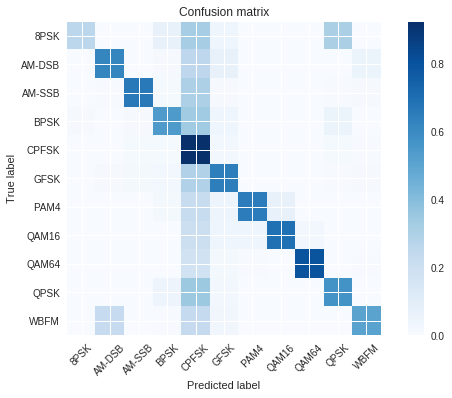

(8060, 2)
(8060, 2, 256)
-20
(403, 514)
403
(403, 512)
SNR:  -20  Overall Accuracy:  0.15384615384615385
-18
(403, 514)
403
(403, 512)
SNR:  -18  Overall Accuracy:  0.15384615384615385
-16
(403, 514)
403
(403, 512)
SNR:  -16  Overall Accuracy:  0.14640198511166252
-14
(403, 514)
403
(403, 512)
SNR:  -14  Overall Accuracy:  0.1513647642679901
-12
(403, 514)
403
(403, 512)
SNR:  -12  Overall Accuracy:  0.21588089330024815
-10
(403, 514)
403
(403, 512)
SNR:  -10  Overall Accuracy:  0.2506203473945409
-8
(403, 514)
403
(403, 512)
SNR:  -8  Overall Accuracy:  0.45905707196029777
-6
(403, 514)
403
(403, 512)
SNR:  -6  Overall Accuracy:  0.5856079404466501
-4
(403, 514)
403
(403, 512)
SNR:  -4  Overall Accuracy:  0.7047146401985112
-2
(403, 514)
403
(403, 512)
SNR:  -2  Overall Accuracy:  0.7245657568238213
0
(403, 514)
403
(403, 512)
SNR:  0  Overall Accuracy:  0.8635235732009926
2
(403, 514)
403
(403, 512)
SNR:  2  Overall Accuracy:  0.8808933002481389
4
(403, 514)
403
(403, 512)
SNR:  4  O

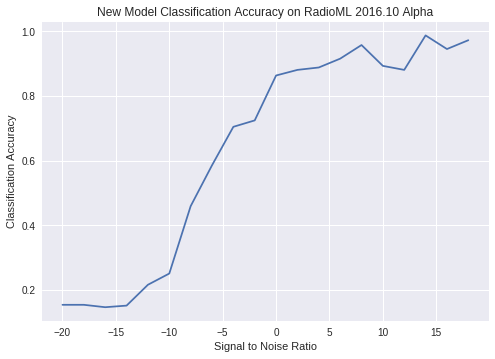

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
classes = mods
test_Y_hat = loaded_model.predict(Data_original_diff_test_3D, batch_size=1024)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
Data_original_diff_test_3D=np.array(Data_original_diff_test_3D)
labels_test_matrix=np.array(labels_test_matrix)
for i in range(0,Data_original_diff_test_3D.shape[0]):
    
    j = list(labels_test_matrix[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
labels_test2 = np.array(labels_test2)
#labels_test2 = np.dstack((labels_test2,labels_test2))
print(labels_test2.shape)
print(Data_original_diff_test_3D.shape)
Data_original_diff_test_3D = Data_original_diff_test_3D.reshape(8060,512)
test_data = np.hstack((Data_original_diff_test_3D,labels_test2))
test_labels = np.hstack((labels_test_matrix,labels_test2))

classes=mods
acc = {}
labels_test = np.array(labels_test)
accuracies=[]
for snr in snrs:
  # extract classes @ SNR
  print(snr)
  test_X_i = test_data[ np.where(test_data[:,513] == str(snr)) ]
  
  print(test_X_i.shape)
  test_Y_i = test_labels[np.where(test_labels[:,12] ==str(snr))]
  print(len(test_Y_i))

  # estimate classes
  test_X_i = np.delete(np.array(test_X_i) , 513 , axis=1)
  test_X_i = np.delete(np.array(test_X_i) , 512 , axis=1)
  print(test_X_i.shape)
  test_Y_i_hat = loaded_model.predict(test_X_i.reshape(403,2,256))
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])

  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index('1')
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print ("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor) )
  acc[snr] = 1.0 * cor / (cor + ncor)
  accuracies.append(1.0 * cor / (cor + ncor))
  


# Plot accuracy curve
plt.plot(snrs, accuracies)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()


In [ ]:
#original and int
''''nb_epoch = 1000   # number of epochs to train on
batch_size = 1024  # training batch size
dr = 0.5 # dropout rate (%)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=50,verbose=0, mode='auto')
callbacks = [earlystop]
in_shp = np.array(Data_original_int_train_3D).shape[1:]
in_shp=list(in_shp)
print(in_shp)
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(64, (1,3), activation="relu" ,input_shape=( 2,128)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(16, (2,3), activation="relu"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(128, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( 11, name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([11]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
np.array(Data_original_int_train_3D).size
np.array(labels_train_matrix).size
Data_original_int_train_3D = np.array(Data_original_int_train_3D)
labels_train_matrix = np.array(labels_train_matrix)
Data_original_int_test_3D = np.array(Data_original_int_test_3D)
labels_test_matrix = np.array(labels_test_matrix)
Data_original_int_validation_3D= np.array(Data_original_int_validation_3D)
labels_validation_matrix = np.array(labels_validation_matrix)
model.fit(Data_original_int_train_3D, labels_train_matrix, epochs=nb_epoch,validation_data=(Data_original_int_validation_3D,labels_validation_matrix), callbacks=callbacks,batch_size=batch_size)
scores=model.evaluate(Data_original_int_test_3D , labels_test_matrix)
print("\n%s: %.2f%%" % (model.metrics_names[1] , scores[1]*100) )
# serialize model to JSON
model_json = model.to_json()
with open("CombCNN2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CombCNN2.h5")
print("Saved model to disk")
files = []
files.append('CombCNN2.json')
files.append('CombCNN2.h5')
upload_files(drive, folder_id, files)

'''
# load json and create model
files = []
files.append('CombCNN2.json')
files.append('CombCNN2.h5')
files_loaded  = load_files(files)
json_file = open('/content/data/CombCNN2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('/content/data/CombCNN2.h5')
print("Loaded model from disk")
Data_original_int_test_3D = np.array(Data_original_int_test_3D)
labels_test_matrix = np.array(labels_test_matrix)
# evaluate loaded model on test data
loaded_model.compile ( loss='categorical_crossentropy' , optimizer='adam' , metrics = ['accuracy'] )
scores=loaded_model.evaluate(Data_original_int_test_3D, labels_test_matrix)
print("\n%s: %.2f%%" % (loaded_model.metrics_names[1] , scores[1]*100) )


title: CombCNN2.h5, id: 1nVq-rV-mKyqNaZ3ZtjgcnFHHJFE884Lw
downloading to /content/data/CombCNN2.h5
title: CombCNN2.json, id: 1bJ_UBQx4-IeWsju9JZl8kddQx83Akkkm
downloading to /content/data/CombCNN2.json
Loaded model from disk
8060/8060 [==============================] - 1s 146us/step

acc: 61.13%


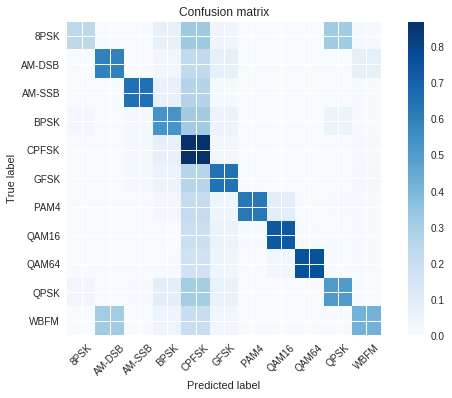

-20
(403, 514)
403
(403, 512)
SNR:  -20  Overall Accuracy:  0.15384615384615385
-18
(403, 514)
403
(403, 512)
SNR:  -18  Overall Accuracy:  0.15384615384615385
-16
(403, 514)
403
(403, 512)
SNR:  -16  Overall Accuracy:  0.15384615384615385
-14
(403, 514)
403
(403, 512)
SNR:  -14  Overall Accuracy:  0.1488833746898263
-12
(403, 514)
403
(403, 512)
SNR:  -12  Overall Accuracy:  0.15384615384615385
-10
(403, 514)
403
(403, 512)
SNR:  -10  Overall Accuracy:  0.18114143920595532
-8
(403, 514)
403
(403, 512)
SNR:  -8  Overall Accuracy:  0.3052109181141439
-6
(403, 514)
403
(403, 512)
SNR:  -6  Overall Accuracy:  0.39950372208436724
-4
(403, 514)
403
(403, 512)
SNR:  -4  Overall Accuracy:  0.3920595533498759
-2
(403, 514)
403
(403, 512)
SNR:  -2  Overall Accuracy:  0.5086848635235732
0
(403, 514)
403
(403, 512)
SNR:  0  Overall Accuracy:  0.5632754342431762
2
(403, 514)
403
(403, 512)
SNR:  2  Overall Accuracy:  0.6799007444168734
4
(403, 514)
403
(403, 512)
SNR:  4  Overall Accuracy:  0.6079

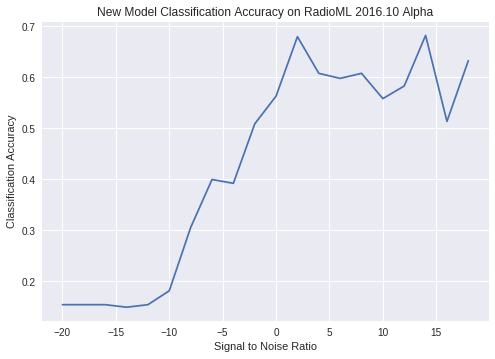

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
classes = mods
test_Y_hat = loaded_model.predict(Data_original_int_test_3D, batch_size=1024)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
Data_original_int_test_3D=np.array(Data_original_int_test_3D)
labels_test_matrix=np.array(labels_test_matrix)
for i in range(0,Data_original_int_test_3D.shape[0]):
    
    j = list(labels_test_matrix[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
labels_test2 = np.array(labels_test2)
#labels_test2 = np.dstack((labels_test2,labels_test2))
'''
Data_original_int_test_3D = Data_original_int_test_3D.reshape(8060,512)
test_data = np.hstack((Data_original_int_test_3D,labels_test2))
test_labels = np.hstack((labels_test_matrix,labels_test2))
'''
classes=mods
acc = {}
labels_test = np.array(labels_test)
accuracies=[]
for snr in snrs:
  # extract classes @ SNR
  print(snr)
  test_X_i = test_data[ np.where(test_data[:,513] == str(snr)) ]
  
  print(test_X_i.shape)
  test_Y_i = test_labels[np.where(test_labels[:,12] ==str(snr))]
  print(len(test_Y_i))

  # estimate classes
  test_X_i = np.delete(np.array(test_X_i) , 513 , axis=1)
  test_X_i = np.delete(np.array(test_X_i) , 512 , axis=1)
  print(test_X_i.shape)
  test_Y_i_hat = loaded_model.predict(test_X_i.reshape(403,2,256))
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])

  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index('1')
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print ("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor) )
  acc[snr] = 1.0 * cor / (cor + ncor)
  accuracies.append(1.0 * cor / (cor + ncor))
  


# Plot accuracy curve
plt.plot(snrs, accuracies)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()


In [ ]:
'''
#diff and int
nb_epoch = 1000   # number of epochs to train on
batch_size = 1024  # training batch size
dr = 0.5 # dropout rate (%)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=50,verbose=0, mode='auto')
callbacks = [earlystop]
in_shp = np.array(Data_int_diff_train_3D).shape[1:]
in_shp=list(in_shp)
print(in_shp)
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(64, (1,3), activation="relu" ,input_shape=( 2,128)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(16, (2,3), activation="relu"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(128, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( 11, name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([11]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
np.array(Data_int_diff_train_3D).size
np.array(labels_train_matrix).size
Data_int_diff_train_3D = np.array(Data_int_diff_train_3D)
labels_train_matrix = np.array(labels_train_matrix)
Data_int_diff_test_3D = np.array(Data_int_diff_test_3D)
labels_test_matrix = np.array(labels_test_matrix)
Data_int_diff_validation_3D= np.array(Data_int_diff_validation_3D)
labels_validation_matrix = np.array(labels_validation_matrix)
model.fit(Data_int_diff_train_3D, labels_train_matrix, epochs=nb_epoch,validation_data=(Data_int_diff_validation_3D,labels_validation_matrix), callbacks=callbacks,batch_size=batch_size)
scores=model.evaluate(Data_int_diff_test_3D , labels_test_matrix)
print("\n%s: %.2f%%" % (model.metrics_names[1] , scores[1]*100) )
# serialize model to JSON
model_json = model.to_json()
with open("CombCNN3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CombCNN3.h5")
print("Saved model to disk")
files = []
files.append('CombCNN3.json')
files.append('CombCNN3.h5')
upload_files(drive, folder_id, files)

'''
# load json and create model
files = []
files.append('CombCNN3.json')
files.append('CombCNN3.h5')
files_loaded  = load_files(files)
json_file = open('/content/data/CombCNN3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('/content/data/CombCNN3.h5')
print("Loaded model from disk")
Data_int_diff_test_3D = np.array(Data_int_diff_test_3D)
labels_test_matrix = np.array(labels_test_matrix)
# evaluate loaded model on test data
loaded_model.compile ( loss='categorical_crossentropy' , optimizer='adam' , metrics = ['accuracy'] )
scores=loaded_model.evaluate(Data_int_diff_test_3D, labels_test_matrix)
print("\n%s: %.2f%%" % (loaded_model.metrics_names[1] , scores[1]*100) )


title: CombCNN3.json, id: 1ZXmtT6qi6a_PVxFzI0y7MPKamTBFFjfH
downloading to /content/data/CombCNN3.json
title: CombCNN3.h5, id: 1k574EtFVyxaqCB9dtxSxgDVaofqbz04h
downloading to /content/data/CombCNN3.h5
Loaded model from disk
8060/8060 [==============================] - 1s 137us/step

acc: 59.91%


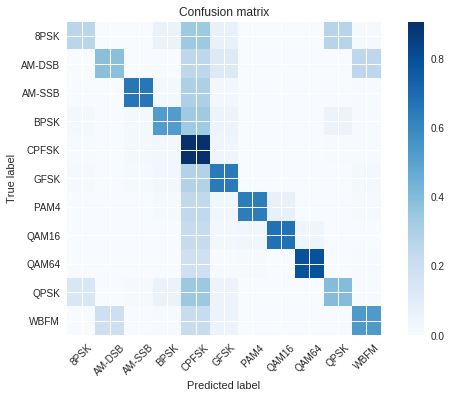

-20
(403, 514)
403
(403, 512)
SNR:  -20  Overall Accuracy:  0.15384615384615385
-18
(403, 514)
403
(403, 512)
SNR:  -18  Overall Accuracy:  0.15384615384615385
-16
(403, 514)
403
(403, 512)
SNR:  -16  Overall Accuracy:  0.15384615384615385
-14
(403, 514)
403
(403, 512)
SNR:  -14  Overall Accuracy:  0.15632754342431762
-12
(403, 514)
403
(403, 512)
SNR:  -12  Overall Accuracy:  0.21588089330024815
-10
(403, 514)
403
(403, 512)
SNR:  -10  Overall Accuracy:  0.23821339950372208
-8
(403, 514)
403
(403, 512)
SNR:  -8  Overall Accuracy:  0.456575682382134
-6
(403, 514)
403
(403, 512)
SNR:  -6  Overall Accuracy:  0.5533498759305211
-4
(403, 514)
403
(403, 512)
SNR:  -4  Overall Accuracy:  0.630272952853598
-2
(403, 514)
403
(403, 512)
SNR:  -2  Overall Accuracy:  0.6650124069478908
0
(403, 514)
403
(403, 512)
SNR:  0  Overall Accuracy:  0.8089330024813896
2
(403, 514)
403
(403, 512)
SNR:  2  Overall Accuracy:  0.7791563275434243
4
(403, 514)
403
(403, 512)
SNR:  4  Overall Accuracy:  0.734491

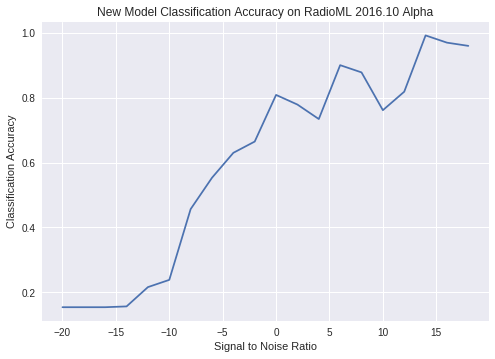

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
classes = mods
test_Y_hat = loaded_model.predict(Data_int_diff_test_3D, batch_size=1024)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
Data_original_int_test_3D=np.array(Data_original_int_test_3D)
labels_test_matrix=np.array(labels_test_matrix)
for i in range(0,Data_int_diff_test_3D.shape[0]):
    
    j = list(labels_test_matrix[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
labels_test2 = np.array(labels_test2)
#labels_test2 = np.dstack((labels_test2,labels_test2))

Data_int_diff_test_3D = Data_int_diff_test_3D.reshape(8060,512)
test_data = np.hstack((Data_int_diff_test_3D,labels_test2))
test_labels = np.hstack((labels_test_matrix,labels_test2))

classes=mods
acc = {}
labels_test = np.array(labels_test)
accuracies=[]
for snr in snrs:
  # extract classes @ SNR
  print(snr)
  test_X_i = test_data[ np.where(test_data[:,513] == str(snr)) ]
  
  print(test_X_i.shape)
  test_Y_i = test_labels[np.where(test_labels[:,12] ==str(snr))]
  print(len(test_Y_i))

  # estimate classes
  test_X_i = np.delete(np.array(test_X_i) , 513 , axis=1)
  test_X_i = np.delete(np.array(test_X_i) , 512 , axis=1)
  print(test_X_i.shape)
  test_Y_i_hat = loaded_model.predict(test_X_i.reshape(403,2,256))
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])

  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index('1')
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print ("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor) )
  acc[snr] = 1.0 * cor / (cor + ncor)
  accuracies.append(1.0 * cor / (cor + ncor))
  


# Plot accuracy curve
plt.plot(snrs, accuracies)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()


In [ ]:
'''
#diff and int and original
nb_epoch = 1000   # number of epochs to train on
batch_size = 1024  # training batch size
dr = 0.5 # dropout rate (%)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=50,verbose=0, mode='auto')
callbacks = [earlystop]
in_shp = np.array(Data_original_diff_int_train_3D).shape[1:]
in_shp=list(in_shp)
print(in_shp)
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(64, (1,3), activation="relu" ,input_shape=( 2,128)))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(16, (2,3), activation="relu"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(128, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( 11, name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([11]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
np.array(Data_original_diff_int_train_3D).size
np.array(labels_train_matrix).size
Data_original_diff_int_train_3D = np.array(Data_original_diff_int_train_3D)
labels_train_matrix = np.array(labels_train_matrix)
Data_original_diff_int_test_3D = np.array(Data_original_diff_int_test_3D)
labels_test_matrix = np.array(labels_test_matrix)
Data_original_diff_int_validation_3D= np.array(Data_original_diff_int_validation_3D)
labels_validation_matrix = np.array(labels_validation_matrix)
model.fit(Data_original_diff_int_train_3D, labels_train_matrix, epochs=nb_epoch,validation_data=(Data_original_diff_int_validation_3D,labels_validation_matrix), callbacks=callbacks,batch_size=batch_size)
scores=model.evaluate(Data_original_diff_int_test_3D , labels_test_matrix)
print("\n%s: %.2f%%" % (model.metrics_names[1] , scores[1]*100) )
# serialize model to JSON
model_json = model.to_json()
with open("CombCNN4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CombCNN4.h5")
print("Saved model to disk")
files = []
files.append('CombCNN4.json')
files.append('CombCNN4.h5')
upload_files(drive, folder_id, files)

'''
# load json and create model
files = []
files.append('CombCNN4.json')
files.append('CombCNN4.h5')
files_loaded  = load_files(files)
json_file = open('/content/data/CombCNN4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('/content/data/CombCNN4.h5')
print("Loaded model from disk")
Data_original_diff_int_test_3D = np.array(Data_original_diff_int_test_3D)
labels_test_matrix = np.array(labels_test_matrix)
# evaluate loaded model on test data
loaded_model.compile ( loss='categorical_crossentropy' , optimizer='adam' , metrics = ['accuracy'] )
scores=loaded_model.evaluate(Data_original_diff_int_test_3D, labels_test_matrix)
print("\n%s: %.2f%%" % (loaded_model.metrics_names[1] , scores[1]*100) )


[2, 384]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 2, 384, 1)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 2, 388, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 386, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 386, 64)        0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 2, 390, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 388, 16)        6160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 388, 16)        0         
_

145760/145760 [==============================] - 19s 131us/step - loss: 2.7745 - acc: 0.1640 - val_loss: 2.2834 - val_acc: 0.1831
Epoch 2/1000
145760/145760 [==============================] - 18s 125us/step - loss: 2.2014 - acc: 0.2116 - val_loss: 2.2240 - val_acc: 0.2243
Epoch 3/1000
145760/145760 [==============================] - 18s 125us/step - loss: 2.0040 - acc: 0.2816 - val_loss: 2.9954 - val_acc: 0.1564
Epoch 4/1000
 10240/145760 [=>............................] - ETA: 16s - loss: 1.8345 - acc: 0.3204

145760/145760 [==============================] - 18s 124us/step - loss: 1.7345 - acc: 0.3469 - val_loss: 2.6807 - val_acc: 0.1792
Epoch 5/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.6350 - acc: 0.3811 - val_loss: 2.4629 - val_acc: 0.1926
Epoch 6/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.5700 - acc: 0.4043 - val_loss: 1.8878 - val_acc: 0.3176
Epoch 7/1000
  5120/145760 [>.............................] - ETA: 17s - loss: 1.5100 - acc: 0.4244

145760/145760 [==============================] - 18s 124us/step - loss: 1.4845 - acc: 0.4295 - val_loss: 1.9015 - val_acc: 0.3420
Epoch 8/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.4465 - acc: 0.4418 - val_loss: 1.6693 - val_acc: 0.3768
Epoch 9/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.4121 - acc: 0.4562 - val_loss: 1.4851 - val_acc: 0.4348
Epoch 10/1000
  4096/145760 [..............................] - ETA: 17s - loss: 1.3640 - acc: 0.4761

145760/145760 [==============================] - 18s 126us/step - loss: 1.3616 - acc: 0.4738 - val_loss: 1.5125 - val_acc: 0.4373
Epoch 11/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.3441 - acc: 0.4817 - val_loss: 1.4664 - val_acc: 0.4709
Epoch 12/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.3249 - acc: 0.4882 - val_loss: 1.4612 - val_acc: 0.4500
Epoch 13/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.3773 - acc: 0.4694

145760/145760 [==============================] - 18s 125us/step - loss: 1.3141 - acc: 0.4933 - val_loss: 1.3964 - val_acc: 0.4893
Epoch 14/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.2920 - acc: 0.5023 - val_loss: 1.3740 - val_acc: 0.4928
Epoch 15/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.2817 - acc: 0.5062 - val_loss: 1.4130 - val_acc: 0.4774
Epoch 16/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.2776 - acc: 0.5055

145760/145760 [==============================] - 18s 124us/step - loss: 1.2691 - acc: 0.5106 - val_loss: 1.4220 - val_acc: 0.4703
Epoch 17/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.2634 - acc: 0.5124 - val_loss: 1.3568 - val_acc: 0.4941
Epoch 18/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.2471 - acc: 0.5194 - val_loss: 1.3067 - val_acc: 0.5110
Epoch 19/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.2187 - acc: 0.5264

145760/145760 [==============================] - 18s 125us/step - loss: 1.2336 - acc: 0.5267 - val_loss: 1.3365 - val_acc: 0.5032
Epoch 20/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.2212 - acc: 0.5293 - val_loss: 1.2915 - val_acc: 0.5069
Epoch 21/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.2163 - acc: 0.5326 - val_loss: 1.2766 - val_acc: 0.5123
Epoch 22/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.2137 - acc: 0.5326

145760/145760 [==============================] - 18s 125us/step - loss: 1.2077 - acc: 0.5337 - val_loss: 1.3129 - val_acc: 0.4941
Epoch 23/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.2004 - acc: 0.5364 - val_loss: 1.3584 - val_acc: 0.4896
Epoch 24/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.1912 - acc: 0.5403 - val_loss: 1.3310 - val_acc: 0.5002
Epoch 25/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.1955 - acc: 0.5329

145760/145760 [==============================] - 18s 125us/step - loss: 1.1843 - acc: 0.5430 - val_loss: 1.2571 - val_acc: 0.5256
Epoch 26/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.1771 - acc: 0.5462 - val_loss: 1.2883 - val_acc: 0.5124
Epoch 27/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.1706 - acc: 0.5466 - val_loss: 1.2664 - val_acc: 0.5107
Epoch 28/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.1247 - acc: 0.5729

145760/145760 [==============================] - 18s 124us/step - loss: 1.1640 - acc: 0.5511 - val_loss: 1.2746 - val_acc: 0.5083
Epoch 29/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.1572 - acc: 0.5529 - val_loss: 1.2393 - val_acc: 0.5201
Epoch 30/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.1485 - acc: 0.5573 - val_loss: 1.2255 - val_acc: 0.5311
Epoch 31/1000
  3072/145760 [..............................] - ETA: 18s - loss: 1.1224 - acc: 0.5602

145760/145760 [==============================] - 18s 125us/step - loss: 1.1425 - acc: 0.5607 - val_loss: 1.1981 - val_acc: 0.5461
Epoch 32/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.1395 - acc: 0.5616 - val_loss: 1.2106 - val_acc: 0.5399
Epoch 33/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.1342 - acc: 0.5632 - val_loss: 1.2039 - val_acc: 0.5408
Epoch 34/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.1259 - acc: 0.5661

145760/145760 [==============================] - 18s 124us/step - loss: 1.1241 - acc: 0.5670 - val_loss: 1.1895 - val_acc: 0.5517
Epoch 35/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.1215 - acc: 0.5684 - val_loss: 1.2225 - val_acc: 0.5353
Epoch 36/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.1177 - acc: 0.5680 - val_loss: 1.2177 - val_acc: 0.5316
Epoch 37/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.1444 - acc: 0.5596

145760/145760 [==============================] - 18s 125us/step - loss: 1.1153 - acc: 0.5700 - val_loss: 1.2106 - val_acc: 0.5325
Epoch 38/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.1133 - acc: 0.5708 - val_loss: 1.1923 - val_acc: 0.5473
Epoch 39/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.1122 - acc: 0.5703 - val_loss: 1.2672 - val_acc: 0.5113
Epoch 40/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.1203 - acc: 0.5573

145760/145760 [==============================] - 18s 125us/step - loss: 1.1061 - acc: 0.5716 - val_loss: 1.2355 - val_acc: 0.5260
Epoch 41/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.1031 - acc: 0.5745 - val_loss: 1.1897 - val_acc: 0.5399
Epoch 42/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.0970 - acc: 0.5756 - val_loss: 1.2063 - val_acc: 0.5277
Epoch 43/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0739 - acc: 0.5863

145760/145760 [==============================] - 18s 125us/step - loss: 1.0985 - acc: 0.5763 - val_loss: 1.1883 - val_acc: 0.5413
Epoch 44/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0947 - acc: 0.5787 - val_loss: 1.1918 - val_acc: 0.5371
Epoch 45/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0942 - acc: 0.5782 - val_loss: 1.2014 - val_acc: 0.5385
Epoch 46/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.1047 - acc: 0.5781

145760/145760 [==============================] - 18s 124us/step - loss: 1.0953 - acc: 0.5771 - val_loss: 1.1985 - val_acc: 0.5346
Epoch 47/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.0891 - acc: 0.5802 - val_loss: 1.2811 - val_acc: 0.5142
Epoch 48/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0876 - acc: 0.5805 - val_loss: 1.1593 - val_acc: 0.5601
Epoch 49/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0922 - acc: 0.5729

145760/145760 [==============================] - 18s 125us/step - loss: 1.0839 - acc: 0.5808 - val_loss: 1.2149 - val_acc: 0.5343
Epoch 50/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0871 - acc: 0.5794 - val_loss: 1.1397 - val_acc: 0.5755
Epoch 51/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0808 - acc: 0.5819 - val_loss: 1.1691 - val_acc: 0.5492
Epoch 52/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0696 - acc: 0.5856

145760/145760 [==============================] - 18s 125us/step - loss: 1.0790 - acc: 0.5812 - val_loss: 1.1784 - val_acc: 0.5578
Epoch 53/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0778 - acc: 0.5828 - val_loss: 1.1577 - val_acc: 0.5638
Epoch 54/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0782 - acc: 0.5828 - val_loss: 1.1517 - val_acc: 0.5601
Epoch 55/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0434 - acc: 0.6009

145760/145760 [==============================] - 18s 125us/step - loss: 1.0773 - acc: 0.5828 - val_loss: 1.1358 - val_acc: 0.5708
Epoch 56/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0722 - acc: 0.5848 - val_loss: 1.1543 - val_acc: 0.5610
Epoch 57/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0698 - acc: 0.5848 - val_loss: 1.1269 - val_acc: 0.5682
Epoch 58/1000
  3072/145760 [..............................] - ETA: 18s - loss: 1.0682 - acc: 0.5921

145760/145760 [==============================] - 18s 125us/step - loss: 1.0693 - acc: 0.5862 - val_loss: 1.1534 - val_acc: 0.5642
Epoch 59/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0686 - acc: 0.5857 - val_loss: 1.1685 - val_acc: 0.5598
Epoch 60/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0692 - acc: 0.5846 - val_loss: 1.1857 - val_acc: 0.5481
Epoch 61/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0200 - acc: 0.6107

145760/145760 [==============================] - 18s 125us/step - loss: 1.0641 - acc: 0.5875 - val_loss: 1.1695 - val_acc: 0.5636
Epoch 62/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.0674 - acc: 0.5854 - val_loss: 1.1287 - val_acc: 0.5716
Epoch 63/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0648 - acc: 0.5868 - val_loss: 1.1277 - val_acc: 0.5768
Epoch 64/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0852 - acc: 0.5811

145760/145760 [==============================] - 18s 125us/step - loss: 1.0573 - acc: 0.5894 - val_loss: 1.1566 - val_acc: 0.5779
Epoch 65/1000
145760/145760 [==============================] - 18s 126us/step - loss: 1.0604 - acc: 0.5888 - val_loss: 1.1227 - val_acc: 0.5783
Epoch 66/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0568 - acc: 0.5906 - val_loss: 1.1416 - val_acc: 0.5695
Epoch 67/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0207 - acc: 0.5960

145760/145760 [==============================] - 18s 124us/step - loss: 1.0517 - acc: 0.5921 - val_loss: 1.1523 - val_acc: 0.5818
Epoch 68/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0519 - acc: 0.5937 - val_loss: 1.1365 - val_acc: 0.5754
Epoch 69/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0490 - acc: 0.5941 - val_loss: 1.1570 - val_acc: 0.5659
Epoch 70/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0327 - acc: 0.5911

145760/145760 [==============================] - 18s 125us/step - loss: 1.0505 - acc: 0.5934 - val_loss: 1.1620 - val_acc: 0.5525
Epoch 71/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0470 - acc: 0.5940 - val_loss: 1.1064 - val_acc: 0.5850
Epoch 72/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0500 - acc: 0.5939 - val_loss: 1.1142 - val_acc: 0.5842
Epoch 73/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0403 - acc: 0.5977

145760/145760 [==============================] - 18s 125us/step - loss: 1.0420 - acc: 0.5966 - val_loss: 1.1554 - val_acc: 0.5604
Epoch 74/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0461 - acc: 0.5947 - val_loss: 1.1135 - val_acc: 0.5864
Epoch 75/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0411 - acc: 0.5961 - val_loss: 1.1714 - val_acc: 0.5608
Epoch 76/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0603 - acc: 0.5905

145760/145760 [==============================] - 18s 124us/step - loss: 1.0444 - acc: 0.5968 - val_loss: 1.1130 - val_acc: 0.5766
Epoch 77/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.0419 - acc: 0.5968 - val_loss: 1.1271 - val_acc: 0.5817
Epoch 78/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0390 - acc: 0.5975 - val_loss: 1.2305 - val_acc: 0.5445
Epoch 79/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0393 - acc: 0.5977

145760/145760 [==============================] - 18s 125us/step - loss: 1.0389 - acc: 0.5973 - val_loss: 1.1224 - val_acc: 0.5774
Epoch 80/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.0361 - acc: 0.5993 - val_loss: 1.1199 - val_acc: 0.5777
Epoch 81/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.0385 - acc: 0.5975 - val_loss: 1.1164 - val_acc: 0.5715
Epoch 82/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0276 - acc: 0.5964

145760/145760 [==============================] - 18s 124us/step - loss: 1.0380 - acc: 0.5985 - val_loss: 1.1071 - val_acc: 0.5877
Epoch 83/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0340 - acc: 0.5984 - val_loss: 1.1171 - val_acc: 0.5813
Epoch 84/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0367 - acc: 0.5977 - val_loss: 1.1241 - val_acc: 0.5799
Epoch 85/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0104 - acc: 0.6113

145760/145760 [==============================] - 18s 124us/step - loss: 1.0335 - acc: 0.5987 - val_loss: 1.1352 - val_acc: 0.5777
Epoch 86/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0330 - acc: 0.6000 - val_loss: 1.1166 - val_acc: 0.5874
Epoch 87/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0302 - acc: 0.6008 - val_loss: 1.1125 - val_acc: 0.5949
Epoch 88/1000
  3072/145760 [..............................] - ETA: 18s - loss: 1.0070 - acc: 0.6061

145760/145760 [==============================] - 18s 125us/step - loss: 1.0271 - acc: 0.6008 - val_loss: 1.1186 - val_acc: 0.5803
Epoch 89/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0335 - acc: 0.5993 - val_loss: 1.1250 - val_acc: 0.5860
Epoch 90/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0296 - acc: 0.6012 - val_loss: 1.1391 - val_acc: 0.5877
Epoch 91/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0557 - acc: 0.5889

145760/145760 [==============================] - 18s 125us/step - loss: 1.0268 - acc: 0.6025 - val_loss: 1.1625 - val_acc: 0.5700
Epoch 92/1000
145760/145760 [==============================] - 18s 126us/step - loss: 1.0274 - acc: 0.6012 - val_loss: 1.1156 - val_acc: 0.5846
Epoch 93/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0269 - acc: 0.6020 - val_loss: 1.1267 - val_acc: 0.5882
Epoch 94/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0080 - acc: 0.6100

145760/145760 [==============================] - 18s 124us/step - loss: 1.0290 - acc: 0.6017 - val_loss: 1.0921 - val_acc: 0.5873
Epoch 95/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0249 - acc: 0.6026 - val_loss: 1.1670 - val_acc: 0.5640
Epoch 96/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0223 - acc: 0.6034 - val_loss: 1.1232 - val_acc: 0.5835
Epoch 97/1000
  3072/145760 [..............................] - ETA: 18s - loss: 1.0131 - acc: 0.6064

145760/145760 [==============================] - 18s 125us/step - loss: 1.0246 - acc: 0.6038 - val_loss: 1.1284 - val_acc: 0.5769
Epoch 98/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0227 - acc: 0.6039 - val_loss: 1.1453 - val_acc: 0.5728
Epoch 99/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0177 - acc: 0.6060 - val_loss: 1.0892 - val_acc: 0.5853
Epoch 100/1000
  3072/145760 [..............................] - ETA: 17s - loss: 1.0439 - acc: 0.5928

145760/145760 [==============================] - 18s 125us/step - loss: 1.0213 - acc: 0.6038 - val_loss: 1.1335 - val_acc: 0.5751
Epoch 101/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0218 - acc: 0.6041 - val_loss: 1.1125 - val_acc: 0.5829
Epoch 102/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.0177 - acc: 0.6035 - val_loss: 1.0882 - val_acc: 0.5971
Epoch 103/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9880 - acc: 0.6040

145760/145760 [==============================] - 18s 125us/step - loss: 1.0152 - acc: 0.6056 - val_loss: 1.1883 - val_acc: 0.5695
Epoch 104/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0191 - acc: 0.6063 - val_loss: 1.1158 - val_acc: 0.5767
Epoch 105/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0139 - acc: 0.6080 - val_loss: 1.1343 - val_acc: 0.5840
Epoch 106/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9774 - acc: 0.6191

145760/145760 [==============================] - 18s 124us/step - loss: 1.0173 - acc: 0.6052 - val_loss: 1.1393 - val_acc: 0.5888
Epoch 107/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0171 - acc: 0.6059 - val_loss: 1.1529 - val_acc: 0.5762
Epoch 108/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0133 - acc: 0.6080 - val_loss: 1.1396 - val_acc: 0.5843
Epoch 109/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9583 - acc: 0.6328

145760/145760 [==============================] - 18s 125us/step - loss: 1.0115 - acc: 0.6086 - val_loss: 1.1487 - val_acc: 0.5794
Epoch 110/1000
145760/145760 [==============================] - 18s 124us/step - loss: 1.0104 - acc: 0.6103 - val_loss: 1.1321 - val_acc: 0.5816
Epoch 111/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0095 - acc: 0.6102 - val_loss: 1.1047 - val_acc: 0.5831
Epoch 112/1000
  2048/145760 [..............................] - ETA: 17s - loss: 1.0084 - acc: 0.6089

145760/145760 [==============================] - 18s 125us/step - loss: 1.0115 - acc: 0.6083 - val_loss: 1.1027 - val_acc: 0.5911
Epoch 113/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0044 - acc: 0.6101 - val_loss: 1.1032 - val_acc: 0.5853
Epoch 114/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0079 - acc: 0.6103 - val_loss: 1.1271 - val_acc: 0.5809
Epoch 115/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9981 - acc: 0.6138

145760/145760 [==============================] - 18s 125us/step - loss: 1.0092 - acc: 0.6100 - val_loss: 1.1245 - val_acc: 0.5802
Epoch 116/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0059 - acc: 0.6106 - val_loss: 1.1061 - val_acc: 0.5987
Epoch 117/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0038 - acc: 0.6119 - val_loss: 1.1068 - val_acc: 0.5924
Epoch 118/1000
  2048/145760 [..............................] - ETA: 17s - loss: 1.0116 - acc: 0.6040

145760/145760 [==============================] - 18s 125us/step - loss: 1.0018 - acc: 0.6132 - val_loss: 1.1566 - val_acc: 0.5758
Epoch 119/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0041 - acc: 0.6119 - val_loss: 1.1211 - val_acc: 0.5960
Epoch 120/1000
145760/145760 [==============================] - 18s 125us/step - loss: 1.0015 - acc: 0.6127 - val_loss: 1.0921 - val_acc: 0.5934
Epoch 121/1000
  2048/145760 [..............................] - ETA: 17s - loss: 1.0066 - acc: 0.6099

145760/145760 [==============================] - 18s 125us/step - loss: 0.9996 - acc: 0.6131 - val_loss: 1.0934 - val_acc: 0.5839
Epoch 122/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9996 - acc: 0.6137 - val_loss: 1.0928 - val_acc: 0.5947
Epoch 123/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9993 - acc: 0.6140 - val_loss: 1.0988 - val_acc: 0.5961
Epoch 124/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9823 - acc: 0.6187

145760/145760 [==============================] - 18s 124us/step - loss: 1.0002 - acc: 0.6129 - val_loss: 1.1177 - val_acc: 0.5894
Epoch 125/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9998 - acc: 0.6147 - val_loss: 1.1078 - val_acc: 0.6005
Epoch 126/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9981 - acc: 0.6146 - val_loss: 1.1215 - val_acc: 0.5882
Epoch 127/1000
  2048/145760 [..............................] - ETA: 17s - loss: 1.0101 - acc: 0.6162

145760/145760 [==============================] - 18s 124us/step - loss: 0.9969 - acc: 0.6151 - val_loss: 1.1801 - val_acc: 0.5678
Epoch 128/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9954 - acc: 0.6152 - val_loss: 1.1115 - val_acc: 0.5862
Epoch 129/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9938 - acc: 0.6166 - val_loss: 1.1413 - val_acc: 0.5837
Epoch 130/1000
  2048/145760 [..............................] - ETA: 18s - loss: 1.0147 - acc: 0.6167

145760/145760 [==============================] - 18s 126us/step - loss: 1.0006 - acc: 0.6133 - val_loss: 1.0846 - val_acc: 0.5979
Epoch 131/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9986 - acc: 0.6143 - val_loss: 1.1419 - val_acc: 0.5881
Epoch 132/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9975 - acc: 0.6144 - val_loss: 1.1131 - val_acc: 0.5921
Epoch 133/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9379 - acc: 0.6406

145760/145760 [==============================] - 18s 125us/step - loss: 0.9934 - acc: 0.6162 - val_loss: 1.1297 - val_acc: 0.5898
Epoch 134/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9934 - acc: 0.6156 - val_loss: 1.1010 - val_acc: 0.5903
Epoch 135/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9946 - acc: 0.6157 - val_loss: 1.1512 - val_acc: 0.5947
Epoch 136/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9950 - acc: 0.6260

145760/145760 [==============================] - 18s 125us/step - loss: 0.9900 - acc: 0.6177 - val_loss: 1.1063 - val_acc: 0.5982
Epoch 137/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9904 - acc: 0.6172 - val_loss: 1.0980 - val_acc: 0.6000
Epoch 138/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9931 - acc: 0.6167 - val_loss: 1.1102 - val_acc: 0.5930
Epoch 139/1000
  2048/145760 [..............................] - ETA: 18s - loss: 1.0116 - acc: 0.6118

145760/145760 [==============================] - 18s 126us/step - loss: 0.9922 - acc: 0.6167 - val_loss: 1.1015 - val_acc: 0.6030
Epoch 140/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9900 - acc: 0.6184 - val_loss: 1.1252 - val_acc: 0.5934
Epoch 141/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9899 - acc: 0.6188 - val_loss: 1.1242 - val_acc: 0.5886
Epoch 142/1000
  2048/145760 [..............................] - ETA: 17s - loss: 1.0022 - acc: 0.6172

145760/145760 [==============================] - 18s 124us/step - loss: 0.9910 - acc: 0.6170 - val_loss: 1.1027 - val_acc: 0.5982
Epoch 143/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9897 - acc: 0.6183 - val_loss: 1.1194 - val_acc: 0.5905
Epoch 144/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9894 - acc: 0.6186 - val_loss: 1.1165 - val_acc: 0.5843
Epoch 145/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9508 - acc: 0.6357

145760/145760 [==============================] - 18s 125us/step - loss: 0.9858 - acc: 0.6202 - val_loss: 1.1213 - val_acc: 0.5951
Epoch 146/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9884 - acc: 0.6186 - val_loss: 1.0983 - val_acc: 0.5972
Epoch 147/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9909 - acc: 0.6184 - val_loss: 1.1674 - val_acc: 0.5896
Epoch 148/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9714 - acc: 0.6274

145760/145760 [==============================] - 18s 125us/step - loss: 0.9898 - acc: 0.6174 - val_loss: 1.2164 - val_acc: 0.5763
Epoch 149/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9894 - acc: 0.6186 - val_loss: 1.1820 - val_acc: 0.5778
Epoch 150/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9876 - acc: 0.6183 - val_loss: 1.1372 - val_acc: 0.5903
Epoch 151/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9997 - acc: 0.6079

145760/145760 [==============================] - 18s 125us/step - loss: 0.9850 - acc: 0.6209 - val_loss: 1.1308 - val_acc: 0.5882
Epoch 152/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9836 - acc: 0.6204 - val_loss: 1.1190 - val_acc: 0.5930
Epoch 153/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9861 - acc: 0.6201 - val_loss: 1.1365 - val_acc: 0.5945
Epoch 154/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9714 - acc: 0.6162

145760/145760 [==============================] - 18s 125us/step - loss: 0.9882 - acc: 0.6190 - val_loss: 1.1209 - val_acc: 0.6039
Epoch 155/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9822 - acc: 0.6208 - val_loss: 1.1258 - val_acc: 0.6008
Epoch 156/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9842 - acc: 0.6204 - val_loss: 1.1039 - val_acc: 0.6061
Epoch 157/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9897 - acc: 0.6206

145760/145760 [==============================] - 18s 125us/step - loss: 0.9863 - acc: 0.6198 - val_loss: 1.1120 - val_acc: 0.5981
Epoch 158/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9850 - acc: 0.6199 - val_loss: 1.1456 - val_acc: 0.5712
Epoch 159/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9829 - acc: 0.6208 - val_loss: 1.1206 - val_acc: 0.5881
Epoch 160/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9670 - acc: 0.6313

145760/145760 [==============================] - 18s 126us/step - loss: 0.9827 - acc: 0.6199 - val_loss: 1.1507 - val_acc: 0.5976
Epoch 161/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9838 - acc: 0.6195 - val_loss: 1.1022 - val_acc: 0.6040
Epoch 162/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9831 - acc: 0.6210 - val_loss: 1.1421 - val_acc: 0.5887
Epoch 163/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9904 - acc: 0.6245

145760/145760 [==============================] - 18s 125us/step - loss: 0.9817 - acc: 0.6220 - val_loss: 1.1439 - val_acc: 0.6013
Epoch 164/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9825 - acc: 0.6201 - val_loss: 1.1295 - val_acc: 0.5858
Epoch 165/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9802 - acc: 0.6201 - val_loss: 1.1700 - val_acc: 0.5799
Epoch 166/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9757 - acc: 0.6240

145760/145760 [==============================] - 18s 125us/step - loss: 0.9846 - acc: 0.6210 - val_loss: 1.1652 - val_acc: 0.5860
Epoch 167/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9811 - acc: 0.6215 - val_loss: 1.1829 - val_acc: 0.5871
Epoch 168/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9812 - acc: 0.6214 - val_loss: 1.1340 - val_acc: 0.5824
Epoch 169/1000
  2048/145760 [..............................] - ETA: 17s - loss: 1.0061 - acc: 0.6045

145760/145760 [==============================] - 18s 126us/step - loss: 0.9822 - acc: 0.6207 - val_loss: 1.1487 - val_acc: 0.5890
Epoch 170/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9809 - acc: 0.6225 - val_loss: 1.1242 - val_acc: 0.5989
Epoch 171/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9817 - acc: 0.6220 - val_loss: 1.1262 - val_acc: 0.5949
Epoch 172/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9733 - acc: 0.6182

145760/145760 [==============================] - 18s 125us/step - loss: 0.9781 - acc: 0.6226 - val_loss: 1.0959 - val_acc: 0.5942
Epoch 173/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9753 - acc: 0.6251 - val_loss: 1.1404 - val_acc: 0.5823
Epoch 174/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9753 - acc: 0.6244 - val_loss: 1.0980 - val_acc: 0.6015
Epoch 175/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9960 - acc: 0.6226

145760/145760 [==============================] - 18s 125us/step - loss: 0.9785 - acc: 0.6219 - val_loss: 1.0935 - val_acc: 0.5960
Epoch 176/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9785 - acc: 0.6224 - val_loss: 1.0903 - val_acc: 0.6040
Epoch 177/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9811 - acc: 0.6220 - val_loss: 1.1573 - val_acc: 0.5831
Epoch 178/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9951 - acc: 0.6108

145760/145760 [==============================] - 18s 126us/step - loss: 0.9783 - acc: 0.6227 - val_loss: 1.1137 - val_acc: 0.6107
Epoch 179/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9740 - acc: 0.6240 - val_loss: 1.1092 - val_acc: 0.5966
Epoch 180/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9779 - acc: 0.6227 - val_loss: 1.1219 - val_acc: 0.5951
Epoch 181/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9730 - acc: 0.6147

145760/145760 [==============================] - 18s 125us/step - loss: 0.9799 - acc: 0.6229 - val_loss: 1.1439 - val_acc: 0.5981
Epoch 182/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9747 - acc: 0.6247 - val_loss: 1.1331 - val_acc: 0.6000
Epoch 183/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9783 - acc: 0.6214 - val_loss: 1.1220 - val_acc: 0.5943
Epoch 184/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9417 - acc: 0.6421

145760/145760 [==============================] - 18s 125us/step - loss: 0.9746 - acc: 0.6245 - val_loss: 1.1499 - val_acc: 0.5894
Epoch 185/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9749 - acc: 0.6225 - val_loss: 1.1062 - val_acc: 0.5988
Epoch 186/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9761 - acc: 0.6244 - val_loss: 1.1000 - val_acc: 0.6005
Epoch 187/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9531 - acc: 0.6401

145760/145760 [==============================] - 18s 125us/step - loss: 0.9766 - acc: 0.6231 - val_loss: 1.1161 - val_acc: 0.5984
Epoch 188/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9745 - acc: 0.6233 - val_loss: 1.0972 - val_acc: 0.6010
Epoch 189/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9748 - acc: 0.6247 - val_loss: 1.1392 - val_acc: 0.5965
Epoch 190/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9424 - acc: 0.6392

145760/145760 [==============================] - 18s 125us/step - loss: 0.9702 - acc: 0.6259 - val_loss: 1.1324 - val_acc: 0.5973
Epoch 191/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9719 - acc: 0.6248 - val_loss: 1.1336 - val_acc: 0.6011
Epoch 192/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9717 - acc: 0.6248 - val_loss: 1.1140 - val_acc: 0.5987
Epoch 193/1000
  2048/145760 [..............................] - ETA: 17s - loss: 1.0176 - acc: 0.6147

145760/145760 [==============================] - 18s 125us/step - loss: 0.9727 - acc: 0.6237 - val_loss: 1.1117 - val_acc: 0.5950
Epoch 194/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9717 - acc: 0.6246 - val_loss: 1.1140 - val_acc: 0.5990
Epoch 195/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9721 - acc: 0.6255 - val_loss: 1.0810 - val_acc: 0.5983
Epoch 196/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9757 - acc: 0.6353

145760/145760 [==============================] - 18s 125us/step - loss: 0.9738 - acc: 0.6245 - val_loss: 1.1127 - val_acc: 0.5937
Epoch 197/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9724 - acc: 0.6246 - val_loss: 1.1392 - val_acc: 0.5947
Epoch 198/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9703 - acc: 0.6253 - val_loss: 1.1273 - val_acc: 0.5887
Epoch 199/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9708 - acc: 0.6143

145760/145760 [==============================] - 18s 125us/step - loss: 0.9703 - acc: 0.6256 - val_loss: 1.1475 - val_acc: 0.5910
Epoch 200/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9714 - acc: 0.6250 - val_loss: 1.0954 - val_acc: 0.6061
Epoch 201/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9686 - acc: 0.6268 - val_loss: 1.1062 - val_acc: 0.5955
Epoch 202/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9238 - acc: 0.6455

145760/145760 [==============================] - 18s 124us/step - loss: 0.9724 - acc: 0.6248 - val_loss: 1.1273 - val_acc: 0.5993
Epoch 203/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9755 - acc: 0.6235 - val_loss: 1.1294 - val_acc: 0.5930
Epoch 204/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9665 - acc: 0.6274 - val_loss: 1.1807 - val_acc: 0.5795
Epoch 205/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9374 - acc: 0.6304

145760/145760 [==============================] - 18s 125us/step - loss: 0.9670 - acc: 0.6261 - val_loss: 1.1101 - val_acc: 0.5871
Epoch 206/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9683 - acc: 0.6274 - val_loss: 1.1162 - val_acc: 0.5956
Epoch 207/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9704 - acc: 0.6264 - val_loss: 1.1182 - val_acc: 0.5953
Epoch 208/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9740 - acc: 0.6108

145760/145760 [==============================] - 18s 125us/step - loss: 0.9687 - acc: 0.6257 - val_loss: 1.1156 - val_acc: 0.5937
Epoch 209/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9690 - acc: 0.6262 - val_loss: 1.1628 - val_acc: 0.5859
Epoch 210/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9697 - acc: 0.6265 - val_loss: 1.1142 - val_acc: 0.6012
Epoch 211/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9697 - acc: 0.6152

145760/145760 [==============================] - 18s 125us/step - loss: 0.9679 - acc: 0.6265 - val_loss: 1.1121 - val_acc: 0.5960
Epoch 212/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9648 - acc: 0.6266 - val_loss: 1.1656 - val_acc: 0.5965
Epoch 213/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9698 - acc: 0.6264 - val_loss: 1.1174 - val_acc: 0.6056
Epoch 214/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9484 - acc: 0.6367

145760/145760 [==============================] - 18s 125us/step - loss: 0.9695 - acc: 0.6266 - val_loss: 1.1381 - val_acc: 0.5938
Epoch 215/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9662 - acc: 0.6268 - val_loss: 1.1470 - val_acc: 0.5867
Epoch 216/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9705 - acc: 0.6258 - val_loss: 1.1154 - val_acc: 0.5958
Epoch 217/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9670 - acc: 0.6367

145760/145760 [==============================] - 18s 125us/step - loss: 0.9663 - acc: 0.6276 - val_loss: 1.1191 - val_acc: 0.5933
Epoch 218/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9668 - acc: 0.6265 - val_loss: 1.1055 - val_acc: 0.5976
Epoch 219/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9684 - acc: 0.6263 - val_loss: 1.1060 - val_acc: 0.6062
Epoch 220/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9694 - acc: 0.6348

145760/145760 [==============================] - 18s 125us/step - loss: 0.9688 - acc: 0.6267 - val_loss: 1.1259 - val_acc: 0.5874
Epoch 221/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9663 - acc: 0.6280 - val_loss: 1.1561 - val_acc: 0.5959
Epoch 222/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9654 - acc: 0.6279 - val_loss: 1.1218 - val_acc: 0.6149
Epoch 223/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9497 - acc: 0.6191

145760/145760 [==============================] - 18s 125us/step - loss: 0.9637 - acc: 0.6275 - val_loss: 1.1673 - val_acc: 0.5943
Epoch 224/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9637 - acc: 0.6281 - val_loss: 1.1122 - val_acc: 0.5971
Epoch 225/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9602 - acc: 0.6292 - val_loss: 1.1364 - val_acc: 0.5913
Epoch 226/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9441 - acc: 0.6323

145760/145760 [==============================] - 18s 125us/step - loss: 0.9612 - acc: 0.6293 - val_loss: 1.1323 - val_acc: 0.5919
Epoch 227/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9657 - acc: 0.6254 - val_loss: 1.1253 - val_acc: 0.5992
Epoch 228/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9663 - acc: 0.6273 - val_loss: 1.0949 - val_acc: 0.6121
Epoch 229/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9207 - acc: 0.6489

145760/145760 [==============================] - 18s 125us/step - loss: 0.9623 - acc: 0.6301 - val_loss: 1.1215 - val_acc: 0.5979
Epoch 230/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9641 - acc: 0.6282 - val_loss: 1.1173 - val_acc: 0.5971
Epoch 231/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9639 - acc: 0.6285 - val_loss: 1.1191 - val_acc: 0.5978
Epoch 232/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9370 - acc: 0.6367

145760/145760 [==============================] - 18s 125us/step - loss: 0.9602 - acc: 0.6292 - val_loss: 1.1491 - val_acc: 0.5944
Epoch 233/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9632 - acc: 0.6288 - val_loss: 1.1397 - val_acc: 0.6021
Epoch 234/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9607 - acc: 0.6288 - val_loss: 1.1389 - val_acc: 0.6005
Epoch 235/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9574 - acc: 0.6245

145760/145760 [==============================] - 18s 125us/step - loss: 0.9602 - acc: 0.6290 - val_loss: 1.0781 - val_acc: 0.6039
Epoch 236/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9621 - acc: 0.6296 - val_loss: 1.1546 - val_acc: 0.5851
Epoch 237/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9610 - acc: 0.6303 - val_loss: 1.1057 - val_acc: 0.5995
Epoch 238/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9389 - acc: 0.6396

145760/145760 [==============================] - 18s 125us/step - loss: 0.9614 - acc: 0.6285 - val_loss: 1.1201 - val_acc: 0.5971
Epoch 239/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9641 - acc: 0.6280 - val_loss: 1.1603 - val_acc: 0.5898
Epoch 240/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9616 - acc: 0.6285 - val_loss: 1.1150 - val_acc: 0.6008
Epoch 241/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9410 - acc: 0.6357

145760/145760 [==============================] - 18s 125us/step - loss: 0.9584 - acc: 0.6304 - val_loss: 1.0900 - val_acc: 0.6001
Epoch 242/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9586 - acc: 0.6310 - val_loss: 1.0988 - val_acc: 0.5973
Epoch 243/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9590 - acc: 0.6304 - val_loss: 1.0810 - val_acc: 0.6057
Epoch 244/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9239 - acc: 0.6450

145760/145760 [==============================] - 18s 125us/step - loss: 0.9606 - acc: 0.6294 - val_loss: 1.1035 - val_acc: 0.5993
Epoch 245/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9625 - acc: 0.6295 - val_loss: 1.1141 - val_acc: 0.5948
Epoch 246/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9577 - acc: 0.6310 - val_loss: 1.0975 - val_acc: 0.6004
Epoch 247/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9760 - acc: 0.6123

145760/145760 [==============================] - 18s 126us/step - loss: 0.9607 - acc: 0.6298 - val_loss: 1.1159 - val_acc: 0.6036
Epoch 248/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9594 - acc: 0.6292 - val_loss: 1.1199 - val_acc: 0.6053
Epoch 249/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9579 - acc: 0.6306 - val_loss: 1.1414 - val_acc: 0.5898
Epoch 250/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9352 - acc: 0.6216

145760/145760 [==============================] - 18s 126us/step - loss: 0.9583 - acc: 0.6294 - val_loss: 1.1470 - val_acc: 0.5859
Epoch 251/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9578 - acc: 0.6310 - val_loss: 1.0941 - val_acc: 0.6063
Epoch 252/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9561 - acc: 0.6312 - val_loss: 1.1371 - val_acc: 0.6016
Epoch 253/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9331 - acc: 0.6460

145760/145760 [==============================] - 18s 125us/step - loss: 0.9539 - acc: 0.6326 - val_loss: 1.1216 - val_acc: 0.6004
Epoch 254/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9559 - acc: 0.6319 - val_loss: 1.1253 - val_acc: 0.5917
Epoch 255/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9576 - acc: 0.6298 - val_loss: 1.1104 - val_acc: 0.5924
Epoch 256/1000
  2048/145760 [..............................] - ETA: 17s - loss: 1.0130 - acc: 0.5894

145760/145760 [==============================] - 18s 125us/step - loss: 0.9594 - acc: 0.6298 - val_loss: 1.1972 - val_acc: 0.5729
Epoch 257/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9551 - acc: 0.6313 - val_loss: 1.1258 - val_acc: 0.5982
Epoch 258/1000
145760/145760 [==============================] - 18s 126us/step - loss: 0.9564 - acc: 0.6316 - val_loss: 1.1578 - val_acc: 0.6030
Epoch 259/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9912 - acc: 0.6309

145760/145760 [==============================] - 18s 125us/step - loss: 0.9583 - acc: 0.6307 - val_loss: 1.1247 - val_acc: 0.5994
Epoch 260/1000
145760/145760 [==============================] - 18s 124us/step - loss: 0.9560 - acc: 0.6316 - val_loss: 1.1514 - val_acc: 0.6040
Epoch 261/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9575 - acc: 0.6309 - val_loss: 1.1385 - val_acc: 0.5891
Epoch 262/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9382 - acc: 0.6411

145760/145760 [==============================] - 18s 125us/step - loss: 0.9537 - acc: 0.6325 - val_loss: 1.1662 - val_acc: 0.5973
Epoch 263/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9548 - acc: 0.6323 - val_loss: 1.1077 - val_acc: 0.6045
Epoch 264/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9546 - acc: 0.6330 - val_loss: 1.1254 - val_acc: 0.6087
Epoch 265/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9968 - acc: 0.6030

145760/145760 [==============================] - 18s 125us/step - loss: 0.9550 - acc: 0.6307 - val_loss: 1.1035 - val_acc: 0.5967
Epoch 266/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9531 - acc: 0.6327 - val_loss: 1.0895 - val_acc: 0.6113
Epoch 267/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9569 - acc: 0.6325 - val_loss: 1.0982 - val_acc: 0.6068
Epoch 268/1000
  2048/145760 [..............................] - ETA: 18s - loss: 0.9313 - acc: 0.6479

145760/145760 [==============================] - 18s 125us/step - loss: 0.9520 - acc: 0.6323 - val_loss: 1.1496 - val_acc: 0.6024
Epoch 269/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9544 - acc: 0.6320 - val_loss: 1.1361 - val_acc: 0.5835
Epoch 270/1000
145760/145760 [==============================] - 18s 125us/step - loss: 0.9553 - acc: 0.6320 - val_loss: 1.0796 - val_acc: 0.6002
Epoch 271/1000
  2048/145760 [..............................] - ETA: 17s - loss: 0.9744 - acc: 0.6245

145760/145760 [==============================] - 18s 125us/step - loss: 0.9577 - acc: 0.6300 - val_loss: 1.1108 - val_acc: 0.6030
Epoch 272/1000
8060/8060 [==============================] - 1s 141us/step

acc: 62.06%
Saved model to disk
Uploading CombCNN4.h5


InvalidConfigError: ignored

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
classes = mods
test_Y_hat = loaded_model.predict(Data_original_diff_int_test_3D, batch_size=1024)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
Data_original_int_test_3D=np.array(Data_original_int_test_3D)
labels_test_matrix=np.array(labels_test_matrix)
for i in range(0,Data_original_diff_int_test_3D.shape[0]):
    
    j = list(labels_test_matrix[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
labels_test2 = np.array(labels_test2)
#labels_test2 = np.dstack((labels_test2,labels_test2))

Data_original_diff_int_test_3D = Data_original_diff_int_test_3D.reshape(8060,768)
test_data = np.hstack((Data_int_diff_test_3D,labels_test2))
test_labels = np.hstack((labels_test_matrix,labels_test2))

classes=mods
acc = {}
labels_test = np.array(labels_test)
accuracies=[]
for snr in snrs:
  # extract classes @ SNR
  print(snr)
  test_X_i = test_data[ np.where(test_data[:,767] == str(snr)) ]
  
  print(test_X_i.shape)
  test_Y_i = test_labels[np.where(test_labels[:,12] ==str(snr))]
  print(len(test_Y_i))

  # estimate classes
  test_X_i = np.delete(np.array(test_X_i) , 767 , axis=1)
  test_X_i = np.delete(np.array(test_X_i) , 766 , axis=1)
  print(test_X_i.shape)
  test_Y_i_hat = loaded_model.predict(test_X_i.reshape(403,2,256))
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])

  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index('1')
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print ("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor) )
  acc[snr] = 1.0 * cor / (cor + ncor)
  accuracies.append(1.0 * cor / (cor + ncor))
  


# Plot accuracy curve
plt.plot(snrs, accuracies)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()
